In [1]:
%pip install tensorflow 
import keras
print(keras.__version__)

Note: you may need to restart the kernel to use updated packages.
3.2.1


In [2]:
%pip install matplotlib
%pip install pandas
%pip install scikit-learn

import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold
from keras.optimizers import Adam

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [3]:
def calculate_moving_average(data, window_size=20):
    """
    Calculates the moving average for the specified window size.

    Parameters:
        data (pd.DataFrame): DataFrame with stock data.
        window_size (int): The size of the moving window.

    Returns:
        pd.DataFrame: DataFrame with moving average added as a new column.
    """
    data['Moving_Average'] = data['Close'].rolling(window=window_size).mean()
    return data

In [4]:
def calculate_rsi(data, window_size=14):
    """
    Calculate the Relative Strength Index (RSI) for the given data.

    Parameters:
        data (pd.DataFrame): DataFrame containing the stock prices.
        window_size (int): The period over which to calculate RSI values.

    Returns:
        pd.DataFrame: DataFrame with the RSI added as a new column.
    """
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window_size).mean()
    avg_loss = loss.rolling(window=window_size).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data['RSI'] = rsi

    return data


In [5]:
df_stocks = pd.read_csv('sp500_stocks.csv')
df_stocks = calculate_moving_average(df_stocks, window_size=15)
sc = MinMaxScaler(feature_range = (0, 1))
scaler = sc.fit(df_stocks[["Close", "High", "Low", "Open", "Volume", 'Moving_Average']])
df_stocks[["Close", "High", "Low", "Open", "Volume", 'Moving_Average']] = scaler.transform(df_stocks[["Close", "High", "Low", "Open", "Volume", 'Moving_Average']])
print(df_stocks[["Close", "High", "Low", "Open", "Volume", 'Moving_Average']].shape)
df_stocks.drop(labels=['Adj Close'], axis='columns', inplace=True)
df_stocks.dropna(inplace=True)
df_stocks.set_index('Symbol', inplace=True)
grouped = df_stocks.groupby(level=0)
df_stocks_dict = {group: group_df for group, group_df in grouped}

(1809291, 6)


# Below sets the data up to predict 1 day in the future

In [6]:
import numpy as np

numdays = 330
windowSize = 25

megaDF = []

for key in df_stocks_dict:
    temp_df = df_stocks_dict[key][(-1 * windowSize):].copy()  # Create a copy of the DataFrame
    temp_df.drop(columns=temp_df.columns[0], axis=1, inplace=True)

    if temp_df.shape[0] == windowSize:  # Check if temp_df has the desired number of rows
        megaDF.append(temp_df.values)  # Append the values to megaDF
    else:
        print(f"Ignoring {key} due to insufficient data for window calculation")
        continue

mega_array = np.array(megaDF)
print(mega_array.shape)

(501, 25, 6)


In [7]:
np.random.seed(42)
tf.random.set_seed(42)

layersNodes = [64, 64, 64]

model = keras.models.Sequential([
    keras.layers.LSTM(layersNodes[0], return_sequences=True, input_shape=[None, 6]),
    keras.layers.Dropout(0.10),
    keras.layers.LSTM(layersNodes[1], return_sequences=True),
    keras.layers.Dropout(0.10),
    keras.layers.LSTM(layersNodes[2], return_sequences=False),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(1)
])
optimizer = Adam(learning_rate=0.001)
model.compile(loss="mse", optimizer=optimizer)


C:\Users\Sean\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# **Below is code that utlizes k-folds cross validation**

In [8]:
k = 5  # Number of folds
epochs = 30
kf = KFold(n_splits=k, shuffle=True, random_state=42)
test = True;
    # Perform model training and evaluation using X_train, y_train, X_val, and y_val
for train_index, val_index in kf.split(mega_array):
    X_train, X_val = mega_array[train_index, 1:], mega_array[val_index, 1:]
    y_train, y_val = mega_array[train_index, 0], mega_array[val_index, 0]

    # Train your model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_val, y_val))

    # Evaluate your model
    loss = model.evaluate(X_val, y_val)
    print("Validation Loss:", loss)

model.save("UPDATE_lstm_model.h5")

Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 6.3046e-04 - val_loss: 8.0072e-04
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.3974e-04 - val_loss: 7.8142e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.2556e-04 - val_loss: 5.7384e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4112e-04 - val_loss: 0.0012
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 8.2059e-04 - val_loss: 6.6779e-04
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8419e-04 - val_loss: 5.9888e-04
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4627e-04 - val_loss: 0.0010
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.9590e-04 - val_loss: 6.9428e-04
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1534e-04 - val_loss: 5.7462e-04
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.8990e-04 - val_loss: 8.1650e-04
Epoch 11/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.4864e-04 - val_loss: 6.6

Validation Loss: 0.00044255334069021046


# BELOW IS CODE AND MODEL TO PREDICT DAYS INTO THE FUTURE

In [9]:
np.random.seed(42)
tf.random.set_seed(42)

layersNodes = [64, 64, 64]

multi_model = keras.models.Sequential([
    keras.layers.LSTM(layersNodes[0], return_sequences=True, input_shape=[None, 6]),
    keras.layers.Dropout(0.10),
    keras.layers.LSTM(layersNodes[1], return_sequences=True),
    keras.layers.Dropout(0.10),
    keras.layers.LSTM(layersNodes[2], return_sequences=False),
    keras.layers.Dropout(0.10),
    keras.layers.Dense(1)
])
optimizer = Adam(learning_rate=0.001)
multi_model.compile(loss="mse", optimizer=optimizer)


In [10]:
windowSize = 25
prediction_days = 2

multiMegaDF = []

for key in df_stocks_dict:
    temp_df = df_stocks_dict[key][(-1 * (windowSize + prediction_days)):].copy()  # Grab the last windowSize + prediction_days days
    temp_df.drop(columns=temp_df.columns[0], axis=1, inplace=True)

    if temp_df.shape[0] == (windowSize + prediction_days):  # Check if temp_df has the desired number of rows
        multiMegaDF.append(temp_df.values)  # Append the values to multiMegaDF
    else:
        print(f"Ignoring {key} due to insufficient data for window calculation")
        continue

multi_mega_array = np.array(multiMegaDF)
print(multi_mega_array.shape)


(501, 27, 6)


In [11]:
for train_index, val_index in kf.split(multi_mega_array):
    multi_X_train, multi_X_val = multi_mega_array[train_index, :-prediction_days], multi_mega_array[val_index, :-prediction_days]
    multi_y_train, multi_y_val = multi_mega_array[train_index, -1], multi_mega_array[val_index, -1]
    
    print(multi_X_train.shape)
    print(multi_X_val.shape)
    print(multi_y_train.shape)
    print(multi_y_val.shape)

    # Train your model
    multi_history = multi_model.fit(multi_X_train, multi_y_train, epochs=epochs, batch_size=32, validation_data=(multi_X_val, multi_y_val))

    # Evaluate your model
    multi_loss = model.evaluate(multi_X_val, multi_y_val)
    print("Validation Loss:", multi_loss)

multi_model.save("multi_lstm_model.h5")


(400, 25, 6)
(101, 25, 6)
(400, 6)
(101, 6)
Epoch 1/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 7.7261e-04 - val_loss: 0.0019
Epoch 2/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.1853e-04 - val_loss: 5.7743e-04
Epoch 3/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.1364e-04 - val_loss: 8.7347e-04
Epoch 4/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5.8537e-04 - val_loss: 5.9412e-04
Epoch 5/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4982e-04 - val_loss: 7.5814e-04
Epoch 6/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.0933e-04 - val_loss: 5.9054e-04
Epoch 7/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8909e-04 - val_loss: 6.1120e-04
Epoch 8/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.8579e-04 - val_loss: 5.7659e-04
Epoch 9/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7569e-04 - val_loss: 5.8460e-04
Epoch 10/30
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6374e-04 - val_loss: 5.8029e-04
Epoch 11/30
13/13 ━━━━━━━━━━━━━━━━━━━━

Validation Loss: 0.0003888351784553379


In [12]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True, title="series"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(windowSize, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(windowSize, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.title(title)
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

In [13]:
def plot_learning_curves(loss, val_loss, title):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.grid(True)

Evaluation: 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6686e-04 


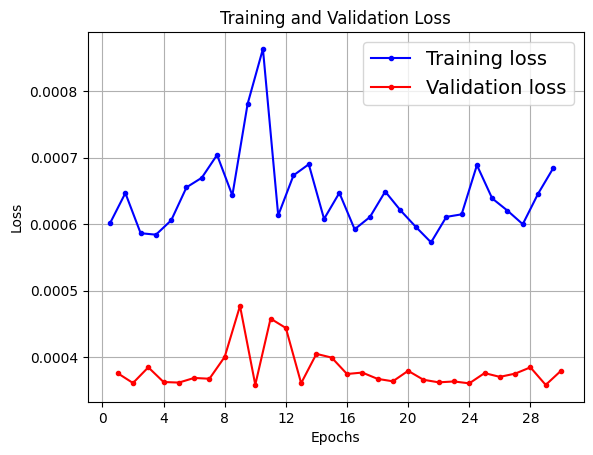

<Figure size 640x480 with 0 Axes>

In [21]:
print("Evaluation: ")
multi_loss = multi_model.evaluate(multi_X_val, multi_y_val)

plot_learning_curves(multi_history.history["loss"], multi_history.history["val_loss"],
                        "Training and Validation Loss")
plt.show()
plt.savefig('loss.png')


file1 = open("parameterTesting.txt", "a")
L = ["windowSize: " + str(windowSize), "   epochs: " + str(epochs),
     "  nodes: " + str(layersNodes[0]) + " " + str(layersNodes[1]) + " " + str(layersNodes[2]),
     "   loss: " + str(loss) + "\n"]
file1.writelines(L)
file1.close()

Evaluation: 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.3557e-04 


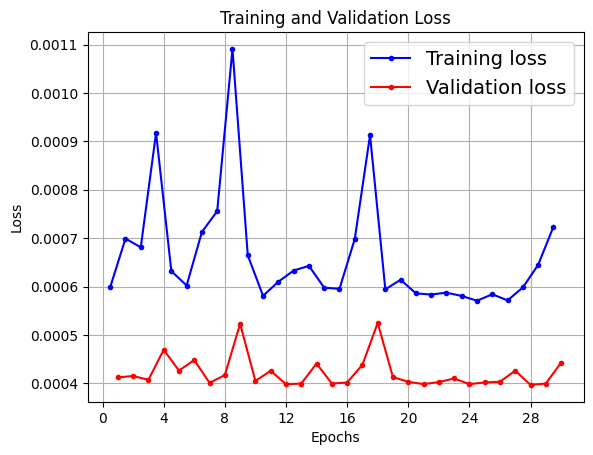

<Figure size 640x480 with 0 Axes>

In [14]:
print("Evaluation: ")
loss = model.evaluate(X_val, y_val)

plot_learning_curves(history.history["loss"], history.history["val_loss"],
                        "Training and Validation Loss")
plt.show()
plt.savefig('loss.png')


file1 = open("parameterTesting.txt", "a")
L = ["windowSize: " + str(windowSize), "   epochs: " + str(epochs),
     "  nodes: " + str(layersNodes[0]) + " " + str(layersNodes[1]) + " " + str(layersNodes[2]),
     "   loss: " + str(loss) + "\n"]
file1.writelines(L)
file1.close()


In [19]:
# Get the stock data for a specific stock
stock_name = "AAPL"  # Replace with the desired stock name
stock_data = df_stocks_dict[stock_name]

# Store the last WindowSize days of stock data
last_days_data = stock_data[-windowSize:].copy()

# Drop the 'Date' column
last_days_data.drop(columns=['Date'], inplace=True)

last_days_data = np.array(last_days_data)
reshaped_arr = last_days_data.reshape(1, windowSize, 6)
print(reshaped_arr.shape)

testPred = multi_model.predict(reshaped_arr)

print(testPred)
testPred = [testPred[0][0], 0,0,0,0,0]
testPred = np.array(testPred)
testPred = testPred.reshape(1, -1)

unscaledPred = scaler.inverse_transform(testPred)
print(unscaledPred)
print("AAPL Prediction for 4/18: " + str(unscaledPred[0][0]))

(1, 25, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.02386576]]
[[193.99497423   0.70999998   0.64999998   0.69999999   0.
    0.75199999]]
AAPL Prediction for 4/18: 193.99497422708484


In [20]:
# Get the stock data for a specific stock
stock_name = "AAPL"  # Replace with the desired stock name
stock_data = df_stocks_dict[stock_name]

# Store the last WindowSize days of stock data
last_days_data = stock_data[-windowSize:].copy()

# Drop the 'Date' column
last_days_data.drop(columns=['Date'], inplace=True)

last_days_data = np.array(last_days_data)
reshaped_arr = last_days_data.reshape(1, windowSize, 6)
print(reshaped_arr.shape)

testPred = model.predict(reshaped_arr)

print(testPred)
testPred = [testPred[0][0], 0,0,0,0,0]
testPred = np.array(testPred)
testPred = testPred.reshape(1, -1)

unscaledPred = scaler.inverse_transform(testPred)
print(unscaledPred)
print("AAPL Prediction for 4/18: " + str(unscaledPred[0][0]))

(1, 25, 6)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
[[0.02612313]]
[[212.27805664   0.70999998   0.64999998   0.69999999   0.
    0.75199999]]
AAPL Prediction for 4/18: 212.27805664499354


(100, 24, 6)
(24, 6)
[0.00163719 0.00163811 0.00165182 0.00163759 0.011215   0.00177325]
[0.00163719 0.00163811 0.00165182 0.00163759 0.011215   0.00177325]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
[[0.01019848]]
[[1.40200005e+01 1.43400002e+01 1.39650002e+01 1.40600004e+01
  3.47314790e+07 1.39213332e+01]]
[83.30016699  0.70999998  0.64999998  0.69999999  0.          0.75199999]


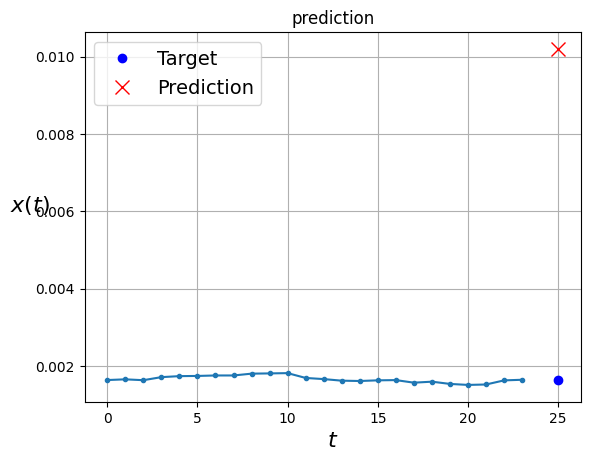

In [17]:
print(X_val.shape)
test = X_val[0]
print(test.shape)
reshaped_arr = test.reshape(1, windowSize -1, 6)

print(reshaped_arr[0][0])
print(test[0])

testPred = model.predict(reshaped_arr)
print(testPred)
testPred = [testPred[0][0], 0,0,0,0,0]
testPred = np.array(testPred)
testPred = testPred.reshape(1, -1)
reshaped_arr = reshaped_arr[0][-1].reshape(1, 6)
print(scaler.inverse_transform(reshaped_arr))
unscaledPred = scaler.inverse_transform(testPred)
print(unscaledPred[0])

plot_series(X_val[0, :, 0], y_val[0, 0], testPred[0, 0], title="prediction")